In [123]:
import pandas as pd
import torch
import ast

# Load the CSV
df = pd.read_csv("light_chembl_smiles_30.csv")

def clean_fragment_sequence(seq_str):
    frag_list = ast.literal_eval(seq_str)
    return [frag.strip().strip("'\"") for frag in frag_list]

df['fragments'] = df['fragments'].apply(clean_fragment_sequence)

# Convert fragment string back to list
#df['fragments'] = df['fragments'].apply(lambda x: x.split(','))

In [124]:
df['fragments'][0]

['[1*]C(=O)C(C([1*])=O)=C1SC=CS1', '[3*]O[3*]', '[4*]C(C)C']

In [125]:
from collections import Counter


# Flatten all fragment lists into a single list
all_fragments = [frag for sublist in df['fragments'] for frag in sublist]

# Count occurrences (optional, can be used to prune rare fragments)
frag_counter = Counter(all_fragments)

# Optional: filter fragments that occur very rarely (e.g., < 2 times)
min_count = 8
vocab_fragments = [frag for frag, count in frag_counter.items() if count >= min_count]

print(f"Number of fragments in vocabulary: {len(vocab_fragments)}")
vocab_fragments[:5]


Number of fragments in vocabulary: 385


['[3*]O[3*]', '[4*]C(C)C', '[4*]C[8*]', '[11*]SC', '[3*]OC']

In [126]:
starting_frags = [frags[0] for frags in df["fragments"] if len(frags) > 0]

# Count how often each starting fragment appears
start_counter = Counter(starting_frags)

# Show the top 5 most frequent starting fragments
top5 = start_counter.most_common(5)

print("Top 5 most frequent starting fragments:")
for frag, count in top5:
    print(f"{frag}: {count}")

Top 5 most frequent starting fragments:
[4*]CC: 660
[16*]c1ccccc1: 371
[1*]C([6*])=O: 294
[5*]N[5*]: 239
[4*]C[8*]: 219


In [127]:
frag2idx = {frag: i for i, frag in enumerate(vocab_fragments)}
idx2frag = {i: frag for frag, i in frag2idx.items()}

# Example: convert fragments of a molecule to indices
df['fragment_indices'] = df['fragments'].apply(lambda frags: [frag2idx[f] for f in frags if f in frag2idx])

In [128]:
print(frag2idx)
print(idx2frag)
print(frag2idx['[4*]CC'], frag2idx['[16*]c1ccccc1'], frag2idx['[1*]C([6*])=O'], frag2idx['[5*]N[5*]'], frag2idx['[4*]C[8*]'])  #five most frequent starting fragments

{'[3*]O[3*]': 0, '[4*]C(C)C': 1, '[4*]C[8*]': 2, '[11*]SC': 3, '[3*]OC': 4, '[1*]C([6*])=O': 5, '[16*]c1ccccc1Cl': 6, '[16*]c1ccccc1': 7, '[4*]C(C)C[8*]': 8, '[5*]N[5*]': 9, '[6*]C([6*])=O': 10, '[16*]c1cccc([16*])c1': 11, '[8*]C(C)C(=O)O': 12, '[8*]C(F)(F)F': 13, '[16*]c1ccc([16*])cc1': 14, '[4*]CC': 15, '[5*]N1CCC[C@H]1[13*]': 16, '[8*]CC': 17, '[6*]C(=O)O': 18, '[16*]c1ccncc1': 19, '[8*]C[8*]': 20, '[6*]C(=O)CO': 21, '[5*]N1CCN([5*])CC1': 22, '[7*]CC[7*]': 23, '[4*]C(C)C([8*])O': 24, '[16*]c1ccc(O)cc1': 25, '[4*]CC([4*])C': 26, '[4*]CCC': 27, '[4*]CC(O)C[4*]': 28, '[4*]CC[4*]': 29, '[5*]N([5*])[5*]': 30, '[9*]n1cncn1': 31, '[16*]c1ccc(F)cc1F': 32, '[1*]C(=O)N(CCCl)N=O': 33, '[16*]c1cnc(C)nc1N': 34, '[16*]c1ccc(C(=N)N)cc1': 35, '[16*]c1ccc(Cl)cc1': 36, '[1*]C(=O)C=C': 37, '[16*]c1cnn(C)c1': 38, '[6*]C(N)=O': 39, '[14*]c1ncccc1[16*]': 40, '[16*]c1cccnc1': 41, '[16*]c1ccccc1[16*]': 42, '[8*]CO': 43, '[11*]S[11*]': 44, '[15*]C1CC1': 45, '[5*]N(C)C': 46, '[15*]C1CCCCC1': 47, '[1*]C(=O)CC

In [129]:
from torch import nn
from torch.utils.data import Dataset, DataLoader

class JTVDataset(Dataset):
    def __init__(self, fragment_indices_list):
        self.data = fragment_indices_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return as tensor
        fragments = self.data[idx]
        return torch.tensor(fragments, dtype=torch.long)
    
def collate_fn(batch):
    # batch is a list of tensors (fragment indices)
    lengths = [len(x) for x in batch]
    max_len = max(lengths)
    
    padded_batch = torch.zeros(len(batch), max_len, dtype=torch.long)
    
    for i, seq in enumerate(batch):
        padded_batch[i, :lengths[i]] = seq
    
    return padded_batch, torch.tensor(lengths, dtype=torch.long)

In [130]:
# Remove molecules that have zero fragments
df = df[df['fragment_indices'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

print("Remaining molecules:", len(df))
dataset = JTVDataset(df['fragment_indices'].tolist())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

Remaining molecules: 7135


In [131]:
for batch, lengths in dataloader:
    print("Batch shape:", batch.shape)
    print("Lengths:", lengths)
    break

Batch shape: torch.Size([16, 5])
Lengths: tensor([3, 1, 5, 2, 5, 4, 3, 4, 5, 1, 3, 2, 2, 2, 3, 4])


In [132]:
import math
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab_fragments)           # from your vocab (frag2idx)
embed_dim = 128                             # fragment embedding dim
enc_hidden = 256                            # encoder GRU hidden size
dec_hidden = 256                            # decoder GRU hidden size
z_dim = 64                                  # latent dim
pad_idx = 0                                 # padding index (we used 0 padding in collate)
batch_size = 16
lr = 1e-3
epochs = 80
teacher_forcing_start = 1.0                 # start prob
teacher_forcing_end = 0.5                   # end prob after anneal
tf_anneal_epochs = 30
kl_anneal_epochs = 60
beta_end = 1.0                                  # final KL weight (you can increase to >1)
max_dec_len = 32                            # safety cap for decoding length



In [133]:
class TreeEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, enc_hidden, batch_first=True)
        self.enc_hidden = enc_hidden

    def forward(self, x, lengths):
        """
        x: [B, L] LongTensor (padded fragment indices)
        lengths: [B] LongTensor
        returns: last_hidden: [B, enc_hidden]
        """
        emb = self.embed(x)  # [B, L, E]
        # pack
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)  # h_n: [1, B, enc_hidden]
        return h_n.squeeze(0)  # [B, enc_hidden]

In [134]:
class LatentHead(nn.Module):
    def __init__(self, enc_hidden, z_dim):
        super().__init__()
        self.linear_mu = nn.Linear(enc_hidden, z_dim)
        self.linear_logvar = nn.Linear(enc_hidden, z_dim)

    def forward(self, h):
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        return mu, logvar

In [135]:
def reparameterize(mu, logvar):
    std = (0.5 * logvar).exp()
    eps = torch.randn_like(std)
    return mu + eps * std

In [136]:
class TreeDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, dec_hidden, z_dim, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.z_to_hidden = nn.Linear(z_dim, dec_hidden)
        # GRU input: embed_dim + z_dim
        self.gru = nn.GRU(embed_dim + z_dim, dec_hidden, batch_first=True)
        self.out = nn.Linear(dec_hidden, vocab_size)

    def init_hidden_from_z(self, z):
        # z: [B, z_dim] -> [1, B, dec_hidden]
        return torch.tanh(self.z_to_hidden(z)).unsqueeze(0)

    def forward(self, inputs, z, hidden=None):
        # Full sequence forward (teacher forcing)
        B, L = inputs.size()
        if hidden is None:
            hidden = self.init_hidden_from_z(z)

        emb = self.embed(inputs)                               # [B,L,E]
        z_exp = z.unsqueeze(1).expand(-1, L, -1)         # [B,L,z_dim]
        gru_input = torch.cat([emb, z_exp], dim=-1)      # [B,L,E+z]
        out, hidden = self.gru(gru_input, hidden)        # [B,L,H]
        logits = self.out(out)                            # [B,L,vocab]
        return logits, hidden

    def step(self, input_token, z, hidden=None):
        """
        Single time-step for autoregressive inference.
        input_token: [B] long
        z: [B, z_dim]
        hidden: previous hidden
        returns logits [B, vocab], new_hidden
        """
        emb = self.embed(input_token).unsqueeze(1)  # [B,1,E]
        gru_in = torch.cat([emb, z.unsqueeze(1)], dim=-1)  # [B,1,E+z]
        out, h_n = self.gru(gru_in, hidden)  # out: [B,1,dec_hidden]
        logits = self.out(out.squeeze(1))  # [B, vocab]
        return logits, h_n


In [139]:
import random
class TreeVAE(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_hidden, dec_hidden, z_dim, pad_idx=0):
        super().__init__()
        self.encoder = TreeEncoder(vocab_size, embed_dim, enc_hidden, pad_idx)
        self.latent = LatentHead(enc_hidden, z_dim)
        self.decoder = TreeDecoder(vocab_size, embed_dim, dec_hidden, z_dim, pad_idx)

    def forward(self, x, lengths, tf_prob=1.0):
        """
        x: [B, L] padded target sequences (we will use teacher forcing)
        lengths: [B] actual lengths
        tf_prob: teacher forcing probability (0..1)
        Returns: logits [B, L, V], mu, logvar
        """
        h_enc = self.encoder(x, lengths)                    # [B, enc_hidden]
        mu, logvar = self.latent(h_enc)                     # [B, z_dim]
        z = reparameterize(mu, logvar).to(device)           # [B, z_dim]

        # Decoder with teacher forcing:
        # For teacher forcing we input the target sequence as inputs (shifted if you want SOS)
        _, hidden = self.decoder(x, z)                       # predict tokens given the inputs (simpler)
        return mu, logvar, z, hidden

    def sample_from_z(self, z, sos_idx=None, max_len=32):
        """
        z: [B, z_dim] latent
        returns: generated indices list (B x <=max_len)
        """
        if sos_idx is None:
            sos_idx = random.choice([15, 7, 5, 9, 2]) #if not specified use top 5 most frequent starting fragments
        self.eval()
        B = z.size(0)
        with torch.no_grad():
            
            # start token: we will assume user uses a special sos index; if none, use first fragment in vocab
            input_tok = torch.full((B,), sos_idx, dtype=torch.long, device=z.device)  # [B]
            hidden = None
            generated = [input_tok.unsqueeze(1)]
            for t in range(max_len):
                logits, hidden = self.decoder.step(input_tok, z, hidden)  # [B, vocab]
                probs = F.softmax(logits, dim=-1)
                # sample or argmax; use sampling to get diverse outputs
                input_tok = torch.multinomial(probs, num_samples=1).squeeze(1)  # [B]
                generated.append(input_tok.unsqueeze(1))
            gen = torch.cat(generated, dim=1)  # [B, max_len]
        return gen  # indices



In [140]:
#loss funtions
def compute_recon_loss(logits, targets, lengths, pad_idx=0):
    """
    logits: [B, L, V]
    targets: [B, L]
    lengths: [B]
    returns: scalar recon loss averaged per batch (sum over real tokens / batch)
    """
    B, L, V = logits.shape
    logits_flat = logits.view(B * L, V)
    targets_flat = targets.view(B * L)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=pad_idx, reduction='sum')
    # normalize by batch size (or number of real tokens if you prefer)
    return loss / B

def compute_kl_freebits(mu, logvar, free_bits=0.5):
    # kl per example (scalar)
    kl_per = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # [B]
    kl_per_clamped = torch.clamp(kl_per - free_bits, min=0.0) + free_bits  # ensures at least free_bits
    return kl_per_clamped.mean()

def linear_anneal(step, total_steps, start=0.0, end=1.0):
    frac = min(1.0, step / float(total_steps))
    return start + frac * (end - start)


In [147]:
#test
model = TreeVAE(vocab_size=vocab_size, embed_dim=embed_dim, enc_hidden=enc_hidden,
                dec_hidden=dec_hidden, z_dim=z_dim, pad_idx=pad_idx).to(device)
with torch.no_grad():
    z_prior = torch.randn(1, z_dim).to(device)
    samples_idx = model.sample_from_z(z_prior, max_len=6)  # [8, L]
    # convert indices to fragment SMILES:
    samples_fraglists = []
    for row in samples_idx.cpu().numpy():
        # convert to fragment strings: break at pad or special tokens if used
        fraglist = [idx2frag[int(i)] for i in row if int(i) in idx2frag]
        samples_fraglists.append(fraglist)
    print("Sampled fragments (example):", samples_fraglists)

Sampled fragments (example): [['[4*]CC', '[15*]C1CC1', '[5*][N+]1(C)CCCC1', '[16*]c1ccc([N+](=O)[O-])cc1', '[3*]OS(C)(=O)=O', '[16*]c1cccc(O)c1', '[4*]CC[8*]']]


In [148]:
model = TreeVAE(vocab_size=vocab_size, embed_dim=embed_dim, enc_hidden=enc_hidden,
                dec_hidden=dec_hidden, z_dim=z_dim, pad_idx=pad_idx).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# assuming dataloader yields (padded_batch, lengths)
global_step = 0

recon_loss_arr = []
kl_arr = []
loss_arr = []
beta_arr = []
tf_arr = []
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_recon = 0.0
    running_kl = 0.0
    # compute annealed scheduler values
    kl_w = linear_anneal(epoch, kl_anneal_epochs, start=0.0, end=beta_end)  # epoch-based
    # teacher forcing probability anneal
    tf_prob = linear_anneal(epoch, tf_anneal_epochs, start=teacher_forcing_start, end=teacher_forcing_end)

    for batch_idx, (padded_batch, lengths) in enumerate(dataloader):
        padded_batch = padded_batch.to(device)   # [B, L]
        lengths = lengths.to(device)
        optimizer.zero_grad()

        mu, logvar, z, hidden0 = model(padded_batch, lengths)  # forward returns these now
        B, T = padded_batch.size()
        
        input_tok = padded_batch[:, 0].to(device)  # or special SOS token
        hidden = hidden0
        logits_list = []
        for t in range(0, padded_batch.size(1)):
            logits_t, hidden = model.decoder.step(input_tok, z, hidden)
            logits_list.append(logits_t.unsqueeze(1))
            # scheduled sampling decision
            use_teacher = (torch.rand(B, device=device) < tf_prob)
            gt_next = padded_batch[:, t].to(device)
            sampled = torch.multinomial(F.softmax(logits_t, dim=-1), 1).squeeze(1)
            input_tok = torch.where(use_teacher, gt_next, sampled)

        logits = torch.cat(logits_list, dim=1)
        recon_loss = compute_recon_loss(logits, padded_batch, lengths, pad_idx=pad_idx)
        kl_loss = compute_kl_freebits(mu, logvar, free_bits=0.5)  # optional free-bits
        loss = recon_loss + kl_w * kl_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += float(loss.item())
        running_recon += float(recon_loss.item())
        running_kl += float(kl_loss.item())
        global_step += 1

    avg_loss = running_loss / len(dataloader)
    avg_recon = running_recon / len(dataloader)
    avg_kl = running_kl / len(dataloader)
    recon_loss_arr.append(avg_recon)
    kl_arr.append(avg_kl)
    loss_arr.append(avg_loss)
    beta_arr.append(kl_w)
    tf_arr.append(tf_prob)
    print(f"Epoch {epoch:03d} | Loss {avg_loss:.4f} | Recon {avg_recon:.4f} | KL {avg_kl:.4f} | KLw {kl_w:.3f} | TF {tf_prob:.3f}")

    '''# optional: sample some molecules from learned prior every few epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            z_prior = torch.randn(8, z_dim).to(device)
            samples_idx = model.sample_from_z(z_prior, sos_idx=1, max_len=12)  # [8, L]
            # convert indices to fragment SMILES:
            samples_fraglists = []
            for row in samples_idx.cpu().numpy():
                # convert to fragment strings: break at pad or special tokens if used
                fraglist = [idx2frag[int(i)] for i in row if int(i) in idx2frag]
                samples_fraglists.append(fraglist)
            print("Sampled fragments (example):", samples_fraglists[:4])'''


Epoch 001 | Loss 9.4315 | Recon 9.1130 | KL 19.1125 | KLw 0.017 | TF 0.983
Epoch 002 | Loss 5.5371 | Recon 4.9017 | KL 19.0632 | KLw 0.033 | TF 0.967
Epoch 003 | Loss 4.0791 | Recon 3.4031 | KL 13.5193 | KLw 0.050 | TF 0.950
Epoch 004 | Loss 3.2068 | Recon 2.5879 | KL 9.2836 | KLw 0.067 | TF 0.933
Epoch 005 | Loss 2.5760 | Recon 2.0471 | KL 6.3463 | KLw 0.083 | TF 0.917
Epoch 006 | Loss 2.0528 | Recon 1.6385 | KL 4.1437 | KLw 0.100 | TF 0.900
Epoch 007 | Loss 1.6421 | Recon 1.3315 | KL 2.6624 | KLw 0.117 | TF 0.883
Epoch 008 | Loss 1.2971 | Recon 1.0734 | KL 1.6773 | KLw 0.133 | TF 0.867
Epoch 009 | Loss 1.0218 | Recon 0.8681 | KL 1.0242 | KLw 0.150 | TF 0.850
Epoch 010 | Loss 0.8228 | Recon 0.7000 | KL 0.7368 | KLw 0.167 | TF 0.833
Epoch 011 | Loss 0.6836 | Recon 0.5739 | KL 0.5984 | KLw 0.183 | TF 0.817
Epoch 012 | Loss 0.5611 | Recon 0.4532 | KL 0.5392 | KLw 0.200 | TF 0.800
Epoch 013 | Loss 0.5137 | Recon 0.4009 | KL 0.5208 | KLw 0.217 | TF 0.783
Epoch 014 | Loss 0.4420 | Recon 0.3

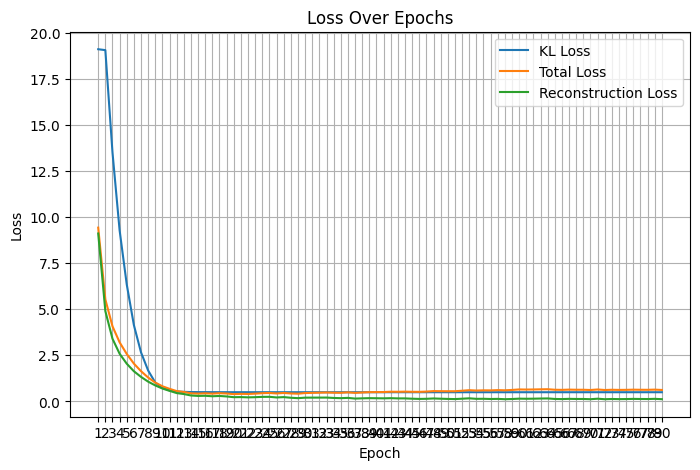

In [149]:
import matplotlib.pyplot as plt

epochs_g = range(1, epochs + 1)  # Start from 1

plt.figure(figsize=(8,5))
plt.plot(epochs_g, kl_arr, label="KL Loss")
plt.plot(epochs_g, loss_arr, label="Total Loss")
plt.plot(epochs_g, recon_loss_arr, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.xticks(epochs_g)  #show each epoch number
plt.legend()
plt.grid(True)
plt.show()

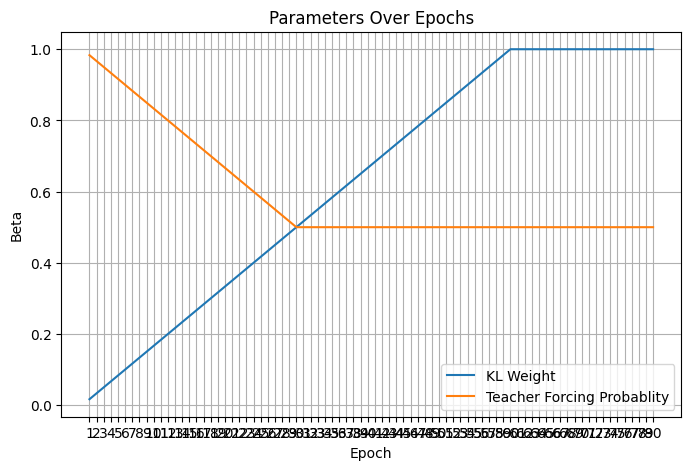

In [150]:
plt.figure(figsize=(8,5))
plt.plot(epochs_g, beta_arr, label="KL Weight")
plt.plot(epochs_g, tf_arr, label="Teacher Forcing Probablity")
plt.xlabel("Epoch")
plt.ylabel("Beta")
plt.title("Parameters Over Epochs")
plt.xticks(epochs_g)  #show each epoch number
plt.legend()
plt.grid(True)
plt.show()

In [164]:
#generate new drug
with torch.no_grad():
    z_prior = torch.randn(2, z_dim).to(device)
    samples_idx = model.sample_from_z(z_prior, max_len=8)  # [8, L]
    # convert indices to fragment SMILES:
    samples_fraglists = []
    for row in samples_idx.cpu().numpy():
        # convert to fragment strings: break at pad or special tokens if used
        fraglist = [idx2frag[int(i)] for i in row if int(i) in idx2frag]
        samples_fraglists.append(fraglist)
    print("Sampled fragments (example):", samples_fraglists)

Sampled fragments (example): [['[16*]c1ccccc1', '[4*]C[C@@H]([8*])O', '[4*]C[C@@H]([8*])O', '[5*]N([5*])[5*]', '[16*]c1cc([16*])c(O)c([16*])c1', '[16*]c1ccccc1', '[16*]c1ccccc1', '[4*]C[C@@H]([8*])O', '[14*]c1ccccn1'], ['[16*]c1ccccc1', '[4*]CC([8*])O', '[1*]C(=O)C[4*]', '[4*]CC([4*])C', '[4*]CC([4*])C', '[5*]N1CCCCC1', '[16*]c1ccccc1', '[16*]c1ccccc1', '[5*]N(C)C']]


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem


def decode_fragments_to_smiles(batch_indices, vocab):
    """
    Convert batch of fragment indices to SMILES
    batch_indices: [B, max_len] LongTensor
    vocab: list of fragment strings
    """
    smiles_list = []
    for seq in batch_indices:
        fragments = [vocab[idx] for idx in seq.tolist()]
        # Simple concatenation (for demo); real JT-VAE uses tree assembly
        mol_str = ".".join(fragments)   # dot-join fragments as placeholder
        try:
            mol = Chem.MolFromSmiles(mol_str)
            if mol is not None:
                smiles_list.append(Chem.MolToSmiles(mol))
            else:
                smiles_list.append(mol_str)  # fallback
        except:
            smiles_list.append(mol_str)
    return smiles_list


In [ ]:
model.eval()
z = torch.randn(1, model.decoder.z_to_hidden.in_features, device=device)
sampled_indices = model.sample_from_z(z, sos_idx=1, max_len=6)  # [5, 12]

smiles_out = decode_fragments_to_smiles(sampled_indices, idx2frag)
for s in smiles_out:
    print(s)
print(smiles_out)

[1*]C([1*])=O.[1*]C([1*])=O.[1*]C([1*])=O.[4*]CCN.[4*]CCN.[5*]N[5*]
['[1*]C([1*])=O.[1*]C([1*])=O.[1*]C([1*])=O.[4*]CCN.[4*]CCN.[5*]N[5*]']


In [ ]:
img = Draw.MolToImage(smiles_out)
img

AttributeError: 'list' object has no attribute 'NeedsUpdatePropertyCache'